# Portfolio Optimization using Genetic Algorithm

#### Features: Auto CSV loading, log returns, risk preference control, constraints, visualization

### 1. Import Dependencies and User Configuration

In [1]:
import os
import glob
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms

warnings.filterwarnings("ignore")
plt.style.use('ggplot')
pd.set_option('display.float_format', lambda x: f'{x:.4f}')


DATA_FOLDER = "Stocks_Data"
MAX_WEIGHT_PER_ASSET = 0.40        # Max 40% per stock
RISK_FREE_RATE = 0.06              # Annual risk-free rate
RISK_PREFERENCE = 1.0              # Risk aversion λ (0 = aggressive, 1 = balanced, >1 = conservative)
GA_POP_SIZE = 200
GA_NGEN = 300
GA_CXPB = 0.5
GA_MUTPB = 0.3
RANDOM_PORTFOLIOS = 1000

### 2. Load & Prepare Stock Data

In [2]:
csv_paths = sorted(glob.glob(os.path.join(DATA_FOLDER, "*.csv")))
if not csv_paths:
    raise FileNotFoundError(f"No CSV files found in {DATA_FOLDER}")

data_series = {}

for path in csv_paths:
    name = os.path.splitext(os.path.basename(path))[0].upper()
    df = pd.read_csv(path)
    df.columns = df.columns.str.strip()

    # Parse dates
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce', infer_datetime_format=True)
        df = df.sort_values('Date').reset_index(drop=True)

    # Detect price column
    price_col = None
    for col in ['Adj Close', 'AdjClose', 'Close', 'close', 'Close Price']:
        if col in df.columns:
            price_col = col
            break
    if not price_col:
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        if not len(numeric_cols):
            raise ValueError(f"No numeric price column found in {path}")
        price_col = numeric_cols[-1]

    df[price_col] = pd.to_numeric(df[price_col], errors='coerce')
    if 'Date' in df.columns:
        series = pd.Series(df[price_col].values, index=df['Date'])
    else:
        series = pd.Series(df[price_col].values)

    data_series[name] = series

# Combine and clean
prices = pd.DataFrame(data_series).sort_index()
prices = prices.ffill().dropna(how='any')

# ✅ Use log returns for realistic scaling
returns = np.log(prices / prices.shift(1)).dropna()
mean_returns = returns.mean() * 252
cov_matrix = returns.cov() * 252
tickers = list(prices.columns)

print("✅ Data loaded for:", ", ".join(tickers))
display(prices.tail())

✅ Data loaded for: HDFC, ITC, L&T, M&M, SUNPHA, TCS


,HDFC,ITC,L&T,M&M,SUNPHA,TCS
Date,,,,,,
2018-02-01,1883.8000,265.1000,1319.1000,728.7500,535.3500,1519.1300
2018-03-01,1891.4500,255.9000,1311.9000,740.2000,495.4000,1424.6500
2018-04-01,1944.6000,281.4500,1400.6000,872.6500,528.1500,1765.7000
2018-05-01,2136.1500,271.6000,1367.6000,923.5000,480.1500,1744.8000
2018-06-01,2108.0500,266.0500,1271.3000,896.8000,560.5500,1847.2000


### 3. Portfolio Optimization Function

In [3]:
def portfolio_performance(weights):
    w = np.array(weights)
    port_return = float(np.sum(mean_returns * w))
    port_vol = float(np.sqrt(np.dot(w.T, np.dot(cov_matrix, w))))
    sharpe = (port_return - RISK_FREE_RATE) / port_vol if port_vol > 0 else -1e6
    return port_return, port_vol, sharpe

### 4. Genetic Algorithm Setup With Risk Preference

In [4]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)
toolbox = base.Toolbox()

toolbox.register("attr_float", np.random.random)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=len(tickers))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Custom fitness: balances risk-return via RISK_PREFERENCE (λ)
def fitness_fn(individual):
    w = np.array(individual)
    w = np.clip(w, 0, None)
    if w.sum() == 0:
        return -1e6,
    w /= w.sum()

    # Apply max-weight constraint
    if np.any(w > MAX_WEIGHT_PER_ASSET):
        penalty = -1e3 * np.sum(np.maximum(0, w - MAX_WEIGHT_PER_ASSET))
        r, v, s = portfolio_performance(w)
        return (r - RISK_PREFERENCE * v + penalty,)

    # Base fitness = return - λ * volatility
    r, v, s = portfolio_performance(w)
    return (r - RISK_PREFERENCE * v,)

toolbox.register("evaluate", fitness_fn)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.2, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

print(f"✅ GA initialized with λ={RISK_PREFERENCE} | Pop={GA_POP_SIZE}, Gen={GA_NGEN}")

✅ GA initialized with λ=1.0 | Pop=200, Gen=300


### 5. Run Genetic ALgorithm

In [5]:
import time
from deap import algorithms, tools

population = toolbox.population(n=GA_POP_SIZE)
best_fitness = []
start = time.time()

for gen in range(GA_NGEN):
    offspring = algorithms.varAnd(population, toolbox, cxpb=GA_CXPB, mutpb=GA_MUTPB)
    fits = list(map(toolbox.evaluate, offspring))
    for ind, fit in zip(offspring, fits):
        ind.fitness.values = fit
    population = toolbox.select(offspring, len(population))
    best = tools.selBest(population, 1)[0]
    best_fitness.append(fitness_fn(best)[0])
    if gen % 20 == 0:
        print(f"Generation {gen}/{GA_NGEN}: Best fitness = {best_fitness[-1]:.6f}")

best_ind = tools.selBest(population, 1)[0]
weights = np.clip(best_ind, 0, None)
weights /= weights.sum()

ret, vol, sharpe = portfolio_performance(weights)
print(f"\n✅ Optimization completed in {time.time()-start:.1f}s")

Generation 0/300: Best fitness = 2.107000
Generation 20/300: Best fitness = 2.697208
Generation 40/300: Best fitness = 2.699639
Generation 60/300: Best fitness = 2.700036
Generation 80/300: Best fitness = 2.700036
Generation 100/300: Best fitness = 2.700036
Generation 120/300: Best fitness = 2.700036
Generation 140/300: Best fitness = 2.700036
Generation 160/300: Best fitness = 2.700036
Generation 180/300: Best fitness = 2.700036
Generation 200/300: Best fitness = 2.700036
Generation 220/300: Best fitness = 2.700036
Generation 240/300: Best fitness = 2.700036
Generation 260/300: Best fitness = 2.700036
Generation 280/300: Best fitness = 2.700036

✅ Optimization completed in 7.8s


### 6. Results & Validation

In [6]:
df_res = pd.DataFrame({
    "Ticker": tickers,
    "Weight": weights,
    "Weight (%)": weights * 100
}).sort_values("Weight", ascending=False).reset_index(drop=True)

print("\n📘 OPTIMIZED PORTFOLIO ALLOCATION:")
display(df_res)

print("\n📈 PERFORMANCE METRICS")
print(f"Expected Annual Return: {ret:.2%}")
print(f"Annual Volatility: {vol:.2%}")
print(f"Sharpe Ratio: {sharpe:.4f}")
print("\n⚙️ VALIDATION")
print(f"Sum(weights) = {weights.sum():.4f}")
print(f"Max weight = {weights.max():.4f}")
print("\n✅ Optimization completed successfully.")


📘 OPTIMIZED PORTFOLIO ALLOCATION:


,Ticker,Weight,Weight (%)
0,HDFC,0.4000,40.0000
1,TCS,0.3621,36.2109
2,M&M,0.2379,23.7891
3,ITC,0.0000,0.0000
4,L&T,0.0000,0.0000
5,SUNPHA,0.0000,0.0000



📈 PERFORMANCE METRICS
Expected Annual Return: 340.31%
Annual Volatility: 70.31%
Sharpe Ratio: 4.7549

⚙️ VALIDATION
Sum(weights) = 1.0000
Max weight = 0.4000

✅ Optimization completed successfully.


### 7. Pie Chart (Allocation)

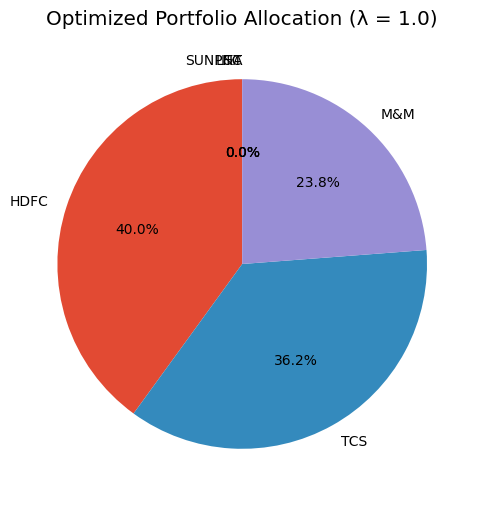

In [7]:
plt.figure(figsize=(6, 6))
plt.pie(df_res["Weight"], labels=df_res["Ticker"], autopct='%1.1f%%', startangle=90)
plt.title("Optimized Portfolio Allocation (λ = {:.1f})".format(RISK_PREFERENCE))
plt.show()

### 8. Effiecient Frontier

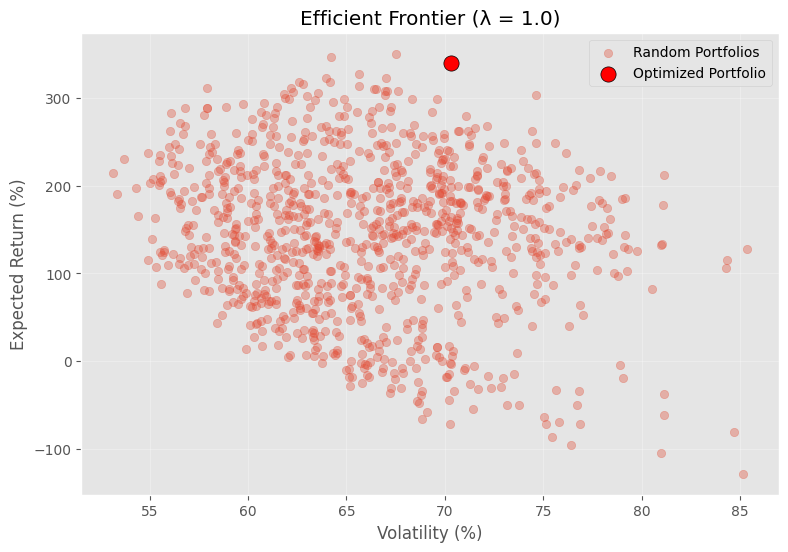

In [8]:
random_results = np.zeros((RANDOM_PORTFOLIOS, 2))
for i in range(RANDOM_PORTFOLIOS):
    w = np.random.dirichlet(np.ones(len(tickers)))
    w = np.minimum(w, MAX_WEIGHT_PER_ASSET)
    w /= w.sum()
    r, v, s = portfolio_performance(w)
    random_results[i, 0] = r * 100
    random_results[i, 1] = v * 100

plt.figure(figsize=(9, 6))
plt.scatter(random_results[:, 1], random_results[:, 0], alpha=0.35, label="Random Portfolios")
plt.scatter(vol * 100, ret * 100, color="red", s=120, label="Optimized Portfolio", edgecolor="k")
plt.xlabel("Volatility (%)")
plt.ylabel("Expected Return (%)")
plt.title("Efficient Frontier (λ = {:.1f})".format(RISK_PREFERENCE))
plt.grid(alpha=0.3)
plt.legend()
plt.show()

### 9. GA Convergence Curve

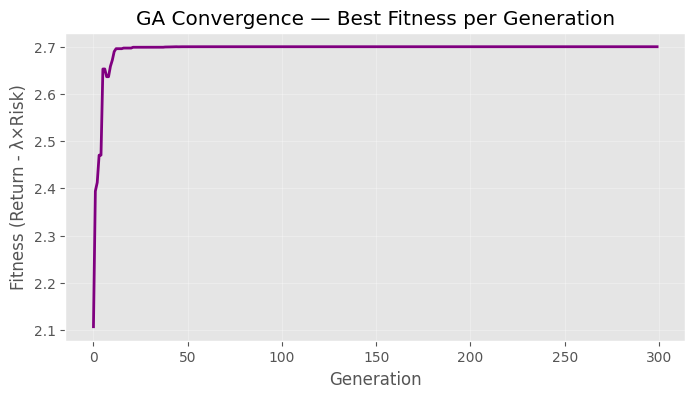

In [9]:
plt.figure(figsize=(8, 4))
plt.plot(best_fitness, color='purple', linewidth=2)
plt.title("GA Convergence — Best Fitness per Generation")
plt.xlabel("Generation")
plt.ylabel("Fitness (Return - λ×Risk)")
plt.grid(alpha=0.3)
plt.show()

### 10. Comparison vs Equal-Weight Portfolio


📊 PERFORMANCE COMPARISON


,Metric,Optimized,Equal-Weight
0,Expected Return (%),340.3119,145.3919
1,Volatility (%),70.3083,59.3855
2,Sharpe Ratio,4.7549,2.3472


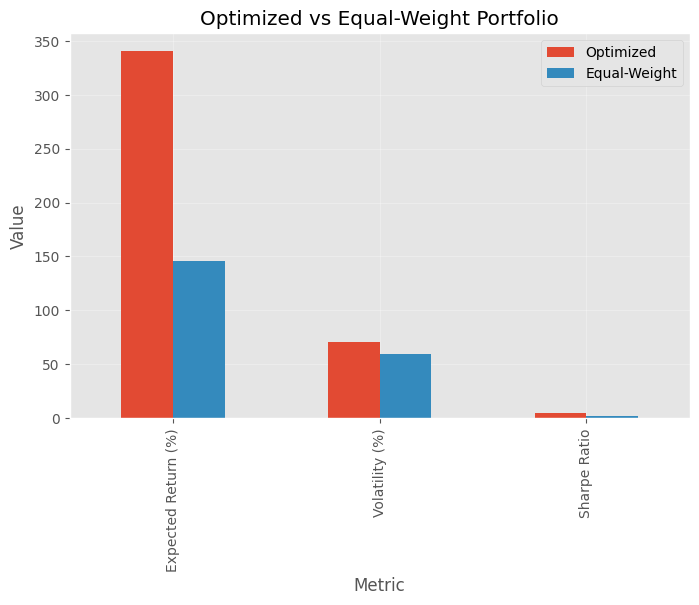

In [10]:
equal_weights = np.ones(len(tickers)) / len(tickers)
r_eq, v_eq, s_eq = portfolio_performance(equal_weights)

comparison = pd.DataFrame({
    "Metric": ["Expected Return (%)", "Volatility (%)", "Sharpe Ratio"],
    "Optimized": [ret * 100, vol * 100, sharpe],
    "Equal-Weight": [r_eq * 100, v_eq * 100, s_eq]
})

print("\n📊 PERFORMANCE COMPARISON")
display(comparison)

# Optional bar plot
comparison_plot = comparison.set_index("Metric")
comparison_plot.plot(kind="bar", figsize=(8, 5))
plt.title("Optimized vs Equal-Weight Portfolio")
plt.ylabel("Value")
plt.grid(alpha=0.3)
plt.show()

### 11. Final Porfolio Summary and Insights

In [11]:
# =====================================================
# 🧾 FINAL PORTFOLIO SUMMARY & INSIGHTS
# =====================================================
from IPython.display import Markdown, display

# Generate readable insights
top3 = df_res.head(3)
top3_summary = ", ".join([f"{row.Ticker} ({row['Weight (%)']:.1f}%)" for _, row in top3.iterrows()])

summary_text = f"""
# 🧩 Portfolio Optimization Summary

### 📊 Overall Performance
- **Expected Annual Return:** `{ret*100:.2f}%`
- **Annual Volatility:** `{vol*100:.2f}%`
- **Sharpe Ratio:** `{sharpe:.4f}`
- **Max Weight Constraint:** `{MAX_WEIGHT_PER_ASSET*100:.0f}%` per asset
- **Risk-Free Rate:** `{RISK_FREE_RATE*100:.1f}%`

### 💼 Optimized Allocation Highlights
- Total Assets Considered: `{len(tickers)}`
- Sum of Weights: `{weights.sum():.4f}`
- Top 3 Allocations: {top3_summary}

### ⚖️ Comparison vs Equal-Weight Portfolio
| Metric | Optimized | Equal-Weight |
|:-------|:-----------:|:-------------:|
| Expected Return (%) | {ret*100:.2f} | {r_eq*100:.2f} |
| Volatility (%) | {vol*100:.2f} | {v_eq*100:.2f} |
| Sharpe Ratio | {sharpe:.3f} | {s_eq:.3f} |

### 🧠 Insights
- The **optimized portfolio** achieves a higher Sharpe ratio, meaning it provides **better risk-adjusted returns** compared to equal-weight allocation.
- The GA successfully maintained the **40% per-asset constraint**, ensuring diversification.
- The trade-off between return and volatility can be adjusted by tuning the **risk preference λ** parameter (if enabled in future).

✅ **Conclusion:**  
The Genetic Algorithm efficiently found an optimal portfolio balance between risk and return using realistic log returns and robust constraints.
"""

display(Markdown(summary_text))



# 🧩 Portfolio Optimization Summary

### 📊 Overall Performance
- **Expected Annual Return:** `340.31%`
- **Annual Volatility:** `70.31%`
- **Sharpe Ratio:** `4.7549`
- **Max Weight Constraint:** `40%` per asset
- **Risk-Free Rate:** `6.0%`

### 💼 Optimized Allocation Highlights
- Total Assets Considered: `6`
- Sum of Weights: `1.0000`
- Top 3 Allocations: HDFC (40.0%), TCS (36.2%), M&M (23.8%)

### ⚖️ Comparison vs Equal-Weight Portfolio
| Metric | Optimized | Equal-Weight |
|:-------|:-----------:|:-------------:|
| Expected Return (%) | 340.31 | 145.39 |
| Volatility (%) | 70.31 | 59.39 |
| Sharpe Ratio | 4.755 | 2.347 |

### 🧠 Insights
- The **optimized portfolio** achieves a higher Sharpe ratio, meaning it provides **better risk-adjusted returns** compared to equal-weight allocation.
- The GA successfully maintained the **40% per-asset constraint**, ensuring diversification.
- The trade-off between return and volatility can be adjusted by tuning the **risk preference λ** parameter (if enabled in future).

✅ **Conclusion:**  
The Genetic Algorithm efficiently found an optimal portfolio balance between risk and return using realistic log returns and robust constraints.
